This notebook is my first implementation of Neural Style Transfer. It will act as a baseline as I experiment with the various settings. This code was adapted from the following book:

&nbsp; &nbsp; &nbsp; &nbsp; *Deep Learning with Python*, Second Edition (pages 383-391)
<br />&nbsp; &nbsp; &nbsp; &nbsp; by Francois Chollet
<br />&nbsp; &nbsp; &nbsp; &nbsp; Manning Press (2021)

Note that I changed some variable names in Chollet's code to match the conventions in my report. I also added code that verifies data at various locations.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Getting the Images

In [2]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

Mounted at /content/drive


In [3]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

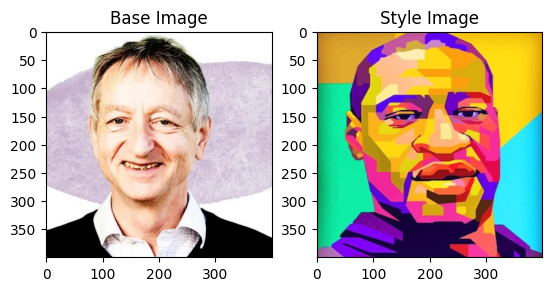

In [4]:
# I'm adding some code to display the images, so I can verify that everything
# looks good.
plt.subplot(1, 2, 1)
base_image = keras.utils.load_img(base_image_path)
plt.imshow(base_image)
plt.title("Base Image")

plt.subplot(1, 2, 2)
style_image = keras.utils.load_img(style_image_path)
plt.imshow(style_image)
plt.title("Style Image")

plt.show()

Auxiliary functions that allow us to work with the images.

In [5]:
# Opens, reizes, and converts an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-center the values by removing the ImageNet mean pixel values.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [6]:
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)

# Make sure that the tensor for the generated image can be changed.
generated_image = tf.Variable(preprocess_image(base_image_path))

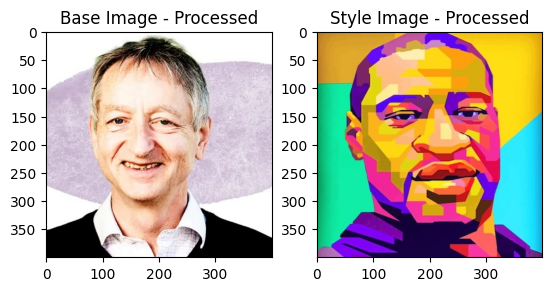

In [7]:
# Again, I'm adding some code here just to make sure everything looks good.
plt.subplot(1, 2, 1)
base_image_display = deprocess_image(base_image)
plt.imshow(base_image_display)
plt.title("Base Image - Processed")

plt.subplot(1, 2, 2)
style_image_display = deprocess_image(style_image)
plt.imshow(style_image_display)
plt.title("Style Image - Processed")

plt.show()

# Setting up the Network

We need to set up the pretrained VGG19 network.

In [8]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# Let's confirm the layers, and have the layer names on hand for later.
print(model.summary())

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# This returns the activation values for every target layer (as a dict).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# Choosing the Content and Style Layers

In [10]:
# For the content loss, use only the deepest layer.
content_layer_name = "block5_conv2"

# For the style loss, use multiple layers.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Defining the Loss Functions

In [11]:
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    # It encourages spatial continuity in the generated image, thus avoiding
    # overly pixelated results.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero.
    loss = tf.zeros(shape=())

    # Add the content loss.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add the style loss.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add the total variation loss.
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

# Performing Gradient Descent

array([[[239, 255, 217],
        [223, 255, 207],
        [208, 255, 204],
        ...,
        [255, 255, 182],
        [255, 255, 203],
        [255, 255, 227]],

       [[217, 255, 201],
        [205, 255, 192],
        [201, 255, 202],
        ...,
        [255, 255, 170],
        [255, 255, 186],
        [255, 255, 202]],

       [[202, 255, 205],
        [197, 255, 202],
        [206, 255, 209],
        ...,
        [255, 255, 186],
        [255, 255, 191],
        [255, 255, 189]],

       ...,

       [[ 25,  47,   0],
        [ 18,  42,   0],
        [ 14,  41,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 13,  41,   0],
        [  8,  46,   0],
        [ 14,  55,   0],
        ...,
        [  0,   5,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  1,  28,   0],
        [  0,  43,   0],
        [ 26,  70,   0],
        ...,
        [  0,   5,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
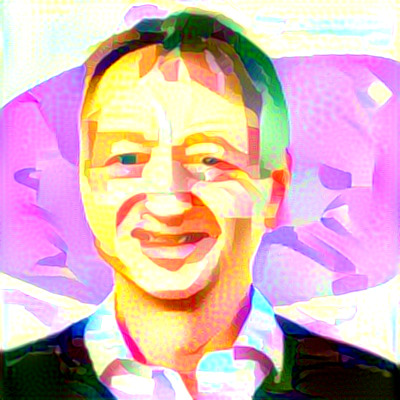

Train step: 4000


In [12]:
# Make the training step faster by compiling it as a tf.function.
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    # Update the output image in a direction that reduces the style transfer loss.
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))